In [34]:
# Python Code for Group Work Machine Learning
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import glob

In [35]:
df_clustered = pd.read_json('df_slim_rotterdam_modified.json', orient='records', lines=True)

In [36]:
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,0
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,0
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,0


In [37]:
# Group data by cluster and time to count the number of ships entering each cluster zone
df_clustered['navigation.time'] = pd.to_datetime(df_clustered['navigation.time'], unit='ms')
df_clustered.set_index('navigation.time', inplace=True)
cluster_counts = df_clustered.groupby([pd.Grouper(freq='D'), 'cluster']).size().unstack(fill_value=0)

In [38]:
cluster_counts

cluster,0,1,2,3,4
navigation.time,,,,,
2021-01-01,577,0,65,2,18
2021-01-02,704,0,0,16,11
2021-01-03,680,9,158,21,31
2021-01-04,461,328,337,71,27
2021-01-05,382,575,468,53,13
2021-01-06,435,134,262,35,46
2021-01-07,674,188,49,203,42
2021-01-08,323,235,185,241,82
2021-01-09,400,140,47,126,47


In [39]:
df_clustered = pd.read_json('df_slim_rotterdam_modified.json', orient='records', lines=True)

# Group data by cluster and time to count the number of ships entering each cluster zone
df_clustered['navigation.time'] = pd.to_datetime(df_clustered['navigation.time'], unit='ms')
df_clustered.set_index('navigation.time', inplace=True)
cluster_counts = df_clustered.groupby([pd.Grouper(freq='D'), 'cluster']).size().unstack(fill_value=0)

# Count the number of ships entering each cluster zone in hourly intervals
hourly_cluster_counts = df_clustered.groupby([pd.Grouper(freq='h'), 'cluster']).size().unstack(fill_value=0)

# Count the number of unique vessel names in hourly intervals for each cluster
unique_vessel_counts = df_clustered.groupby([pd.Grouper(freq='h'), 'cluster'])['vessel.name'].nunique().unstack(fill_value=0)

unique_vessel_counts

cluster,0,1,2,3,4
navigation.time,,,,,
2021-01-01 00:00:00,2,0,1,0,0
2021-01-01 01:00:00,2,0,1,0,0
2021-01-01 02:00:00,2,0,1,0,0
2021-01-01 03:00:00,2,0,1,0,0
2021-01-01 04:00:00,2,0,1,0,0
...,...,...,...,...,...
2021-01-31 19:00:00,2,1,0,0,0
2021-01-31 20:00:00,2,1,0,0,0
2021-01-31 21:00:00,2,1,0,0,0


In [40]:
# Data Preparation
# Prepare the input (X) and target output (y)
lags = 1  # Number of previous time steps to use as features

# Create lag features for each cluster
X = []
y = []

for i in range(lags, len(unique_vessel_counts)):
    # Input: counts of each cluster (0-4) for the previous 'lags' time steps
    X.append(unique_vessel_counts.iloc[i-lags:i].values.flatten())
    # Target: counts of cluster 1 and 4 at the current time step
    y.append(unique_vessel_counts.iloc[i][[1, 4]].values)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

Input shape (X): (743, 5)
Target shape (y): (743, 2)


In [41]:
X

array([[2, 0, 1, 0, 0],
       [2, 0, 1, 0, 0],
       [2, 0, 1, 0, 0],
       ...,
       [2, 1, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [2, 1, 0, 0, 0]], dtype=int64)

In [42]:
y

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [43]:
# Data Splitting
import numpy as np

# Define split ratios
train_size = 0.9
val_size = 0.1

# Calculate indices for splits
train_end = int(train_size * len(X))

# Split the data
X_train, X_val = X[:train_end], X[train_end:]
y_train, y_val = y[:train_end], y[train_end:]


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Define the model
model = Sequential()

# Add an Input layer
model.add(Input(shape=(5,)))  # Assuming 5 input features

# Add hidden layers
model.add(Dense(10, activation='relu'))  # Hidden layer with 10 neurons
model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9042 - val_loss: 0.3286
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4862 - val_loss: 0.2566
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3335 - val_loss: 0.2054
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2530 - val_loss: 0.1731
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2322 - val_loss: 0.1535
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1908 - val_loss: 0.1420
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1899 - val_loss: 0.1299
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1666 - val_loss: 0.1235
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1657 - val_loss: 0.1154
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1688 - val_loss: 0.1120
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1410 - val_loss: 0.1091
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1486 - val_lo

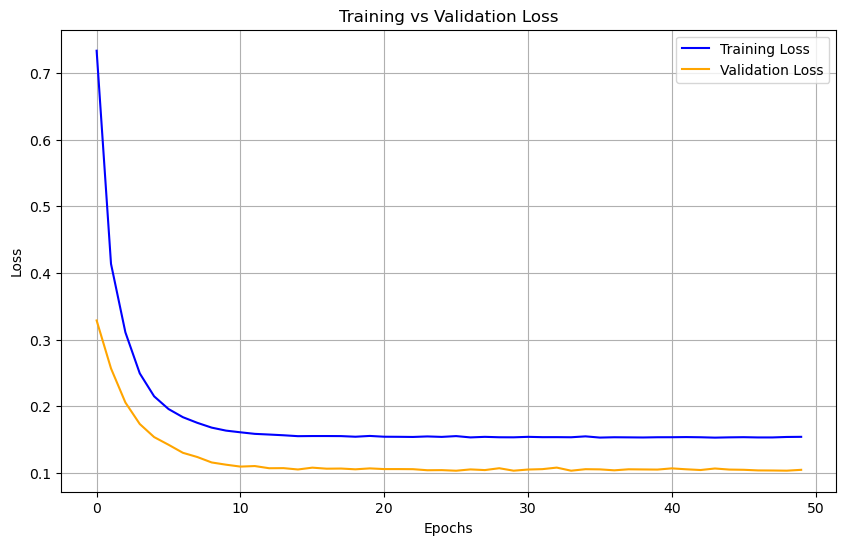

In [45]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [46]:
# Predict the target values using the model
y_pred = model.predict(X_val)

# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Cluster 1': y_val[:, 0],
    'Predicted Cluster 1': y_pred[:, 0],
    'Actual Cluster 4': y_val[:, 1],
    'Predicted Cluster 4': y_pred[:, 1]
})

# Print the comparison table
print(comparison_df)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
    Actual Cluster 1  Predicted Cluster 1  Actual Cluster 4  \
0                  1             1.012908                 0   
1                  1             1.012908                 0   
2                  1             1.012908                 0   
3                  1             1.012908                 0   
4                  1             1.012908                 1   
..               ...                  ...               ...   
70                 1             0.967866                 0   
71                 1             0.967866                 0   
72                 1             0.967866                 0   
73                 1             0.967866                 0   
74                 1             0.967866                 0   

    Predicted Cluster 4  
0              0.123587  
1              0.123587  
2              0.123587  
3              0.123587  
4              0.123587  
..                  ...  
70             0.160458

In [47]:
comparison_df.to_excel('comparison_df.xlsx', index=False)